In [1]:
!pip install --upgrade imbalanced-learn==0.10.1

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


2025-10-25 08:52:57.867632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761382378.123904      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761382378.194396      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (256,256)
BATCH_SIZE = 16
EPOCHS = 100
data_dir = "/kaggle/input/mri-dataset/MRI-CONV--v1"

X = []
y = []

classes = ["NONPD", "PD"]

for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(idx)

X = np.array(X) / 255.0
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
y = np.array(y)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
nsamples, nx, ny, nch = X_train.shape
X_train_flat = X_train.reshape((nsamples, nx*ny*nch))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)

X_train_res = X_train_res.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [5]:
y_train_res_cat = to_categorical(y_train_res, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)


In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761382397.469170      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761382397.469840      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,554 (56.61 MB)

 Trainable params: 14,839,106 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)


In [9]:
history = model.fit(
    X_train_res, y_train_res_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1761382403.727573      71 service.cc:148] XLA service 0x7d13e8013ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761382403.728562      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761382403.728604      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761382404.174380      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/80 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5451 - loss: 3.7397  

I0000 00:00:1761382409.433357      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5884 - loss: 2.8708 - val_accuracy: 0.2523 - val_loss: 12.8468 - learning_rate: 1.0000e-04
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7485 - loss: 0.8189 - val_accuracy: 0.2523 - val_loss: 22.4784 - learning_rate: 1.0000e-04
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7898 - loss: 0.6869 - val_accuracy: 0.2523 - val_loss: 26.8742 - learning_rate: 1.0000e-04
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8400 - loss: 0.6208 - val_accuracy: 0.2523 - val_loss: 25.6694 - learning_rate: 1.0000e-04
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8544 - loss: 0.5635 - val_accuracy: 0.2523 - val_loss: 16.7929 - learning_rate: 1.0000e-04
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8799 - loss: 0.5045 - val_accuracy: 0.2523 - val_loss: 8.6028 - learning_rate: 5.0000e-05
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.913

In [10]:
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=classes))



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step

Classification Report:

              precision    recall  f1-score   support

       NONPD       0.58      0.63      0.60        54
          PD       0.87      0.84      0.86       160

    accuracy                           0.79       214
   macro avg       0.72      0.74      0.73       214
weighted avg       0.80      0.79      0.79       214



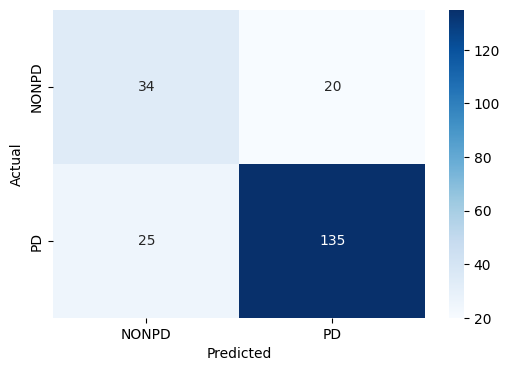

In [11]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"\n Model Performance Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")



 Model Performance Metrics:
Accuracy  : 0.7897
Precision : 0.7966
Recall    : 0.7897
F1 Score  : 0.7927
